<div style="display: flex; align-items: center;">
  <h1 style="font-size: 5em; margin-right: 20px;">Physics Aware Recurrent Convolutional Neural Network: PARC</h1>
  <div>
    <img src="../misc/VIL_logo.png" width="190" alt="Image 1" style="margin-right: 10px;" />
    <img src="../misc/uva.png" width="180" alt="Image 2" style="margin-right: 10px;" />
    <img src="../misc/iowa.png" width="150" alt="Image 3" />
  </div>
</div>

<p>A customizable framework to embed physics in Deep Learning. PARC's formulation is inspired by Advection-Diffusion-Reaction processes and uses an Inductive Bias approach to constrain the Neural Network.</p>


## Normalization

It is assumed that you reviewed the README.md file in our data directory. This provides the format you must convert your data into before normalization (timesteps, channels, height, width). You can find converted data and model weights at: . Then we normalize our variables of interest (channels) between 0 and 1

In [9]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.normalization import compute_min_max

In [10]:
# Example usage
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/NavierStokes/train",
    "/project/vil_baek/data/physics/PARCTorch/NavierStokes/test",
]
output_file = "../data/ns_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/demos
Total files to process: 36
Processed 36/36 files.
Channel-wise min values: [-255955.37392170238, 15.0, -2.757973022522283, -2.673700584310052]
Channel-wise max values: [109451.57268441282, 10000.0, 4.036231420588235, 2.5842768709241444]
Min and max values saved to '/sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/data/ns_min_max.json'.


## Create Data Loader for Training
<p>The <strong>DataLoader</strong> in PyTorch is a crucial utility that facilitates efficient data handling for training and evaluating machine learning models. It abstracts the process of fetching, batching, and shuffling data, ensuring that the model is fed with properly formatted inputs in an optimal way. Specifically, it helps with:</p>

<ul>
    <li><strong>Batching:</strong> Splitting large datasets into smaller, manageable batches to avoid memory overload and enable parallel processing.</li>
    <li><strong>Shuffling:</strong> Randomly ordering data to prevent the model from learning patterns related to the sequence of data (particularly important in training to reduce overfitting).</li>
    <li><strong>Parallel Loading:</strong> It allows the data to be loaded asynchronously using multiple workers, speeding up the training process by loading the next batch while the current one is being processed by the model.</li>
    <li><strong>Custom Collation:</strong> The <code>collate_fn</code> allows customization of how batches are combined, which is essential for complex datasets that require specific handling.</li>
</ul>


In [11]:
# Now import the utilities
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/NavierStokes/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/NavierStokes/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join("..", "data", "ns_min_max.json")  # Correct path
batch_size = 8

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-11-13 12:52:05,882 [INFO] Starting data validation...
2024-11-13 12:52:05,887 [INFO] Validating .npy files...
Validating files: 100%|██████████| 28/28 [00:00<00:00, 321.76it/s]
2024-11-13 12:52:05,979 [INFO] Data validation completed successfully.
2024-11-13 12:52:05,981 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 28/28 [00:00<00:00, 577.70it/s]
2024-11-13 12:52:06,034 [INFO] Total samples in dataset: 1064


<h2>Visualize the Data was Loaded Properly</h2>
<p>Users may select a specific visualization scheme for various applications. If you are unsure how to visualize your data, you can explore various options: 
    <a href="https://matplotlib.org/stable/users/explain/colors/colormaps.html" target="_blank">https://matplotlib.org/stable/users/explain/colors/colormaps.html</a>
</p>


Channel Data Statistics:
Channel 0: IC min=0.6993419528007507, IC max=0.7013699412345886
  Step 1: min=0.6994906663894653, max=0.7014170289039612
Channel 1: IC min=0.008512768894433975, IC max=0.008512768894433975
  Step 1: min=0.008512768894433975, max=0.008512768894433975
Channel 2: IC min=0.37832126021385193, IC max=0.649697482585907
  Step 1: min=0.3333809971809387, max=0.6466608643531799
Channel 3: IC min=0.3567461371421814, IC max=0.6603120565414429
  Step 1: min=0.35497817397117615, max=0.6620773673057556


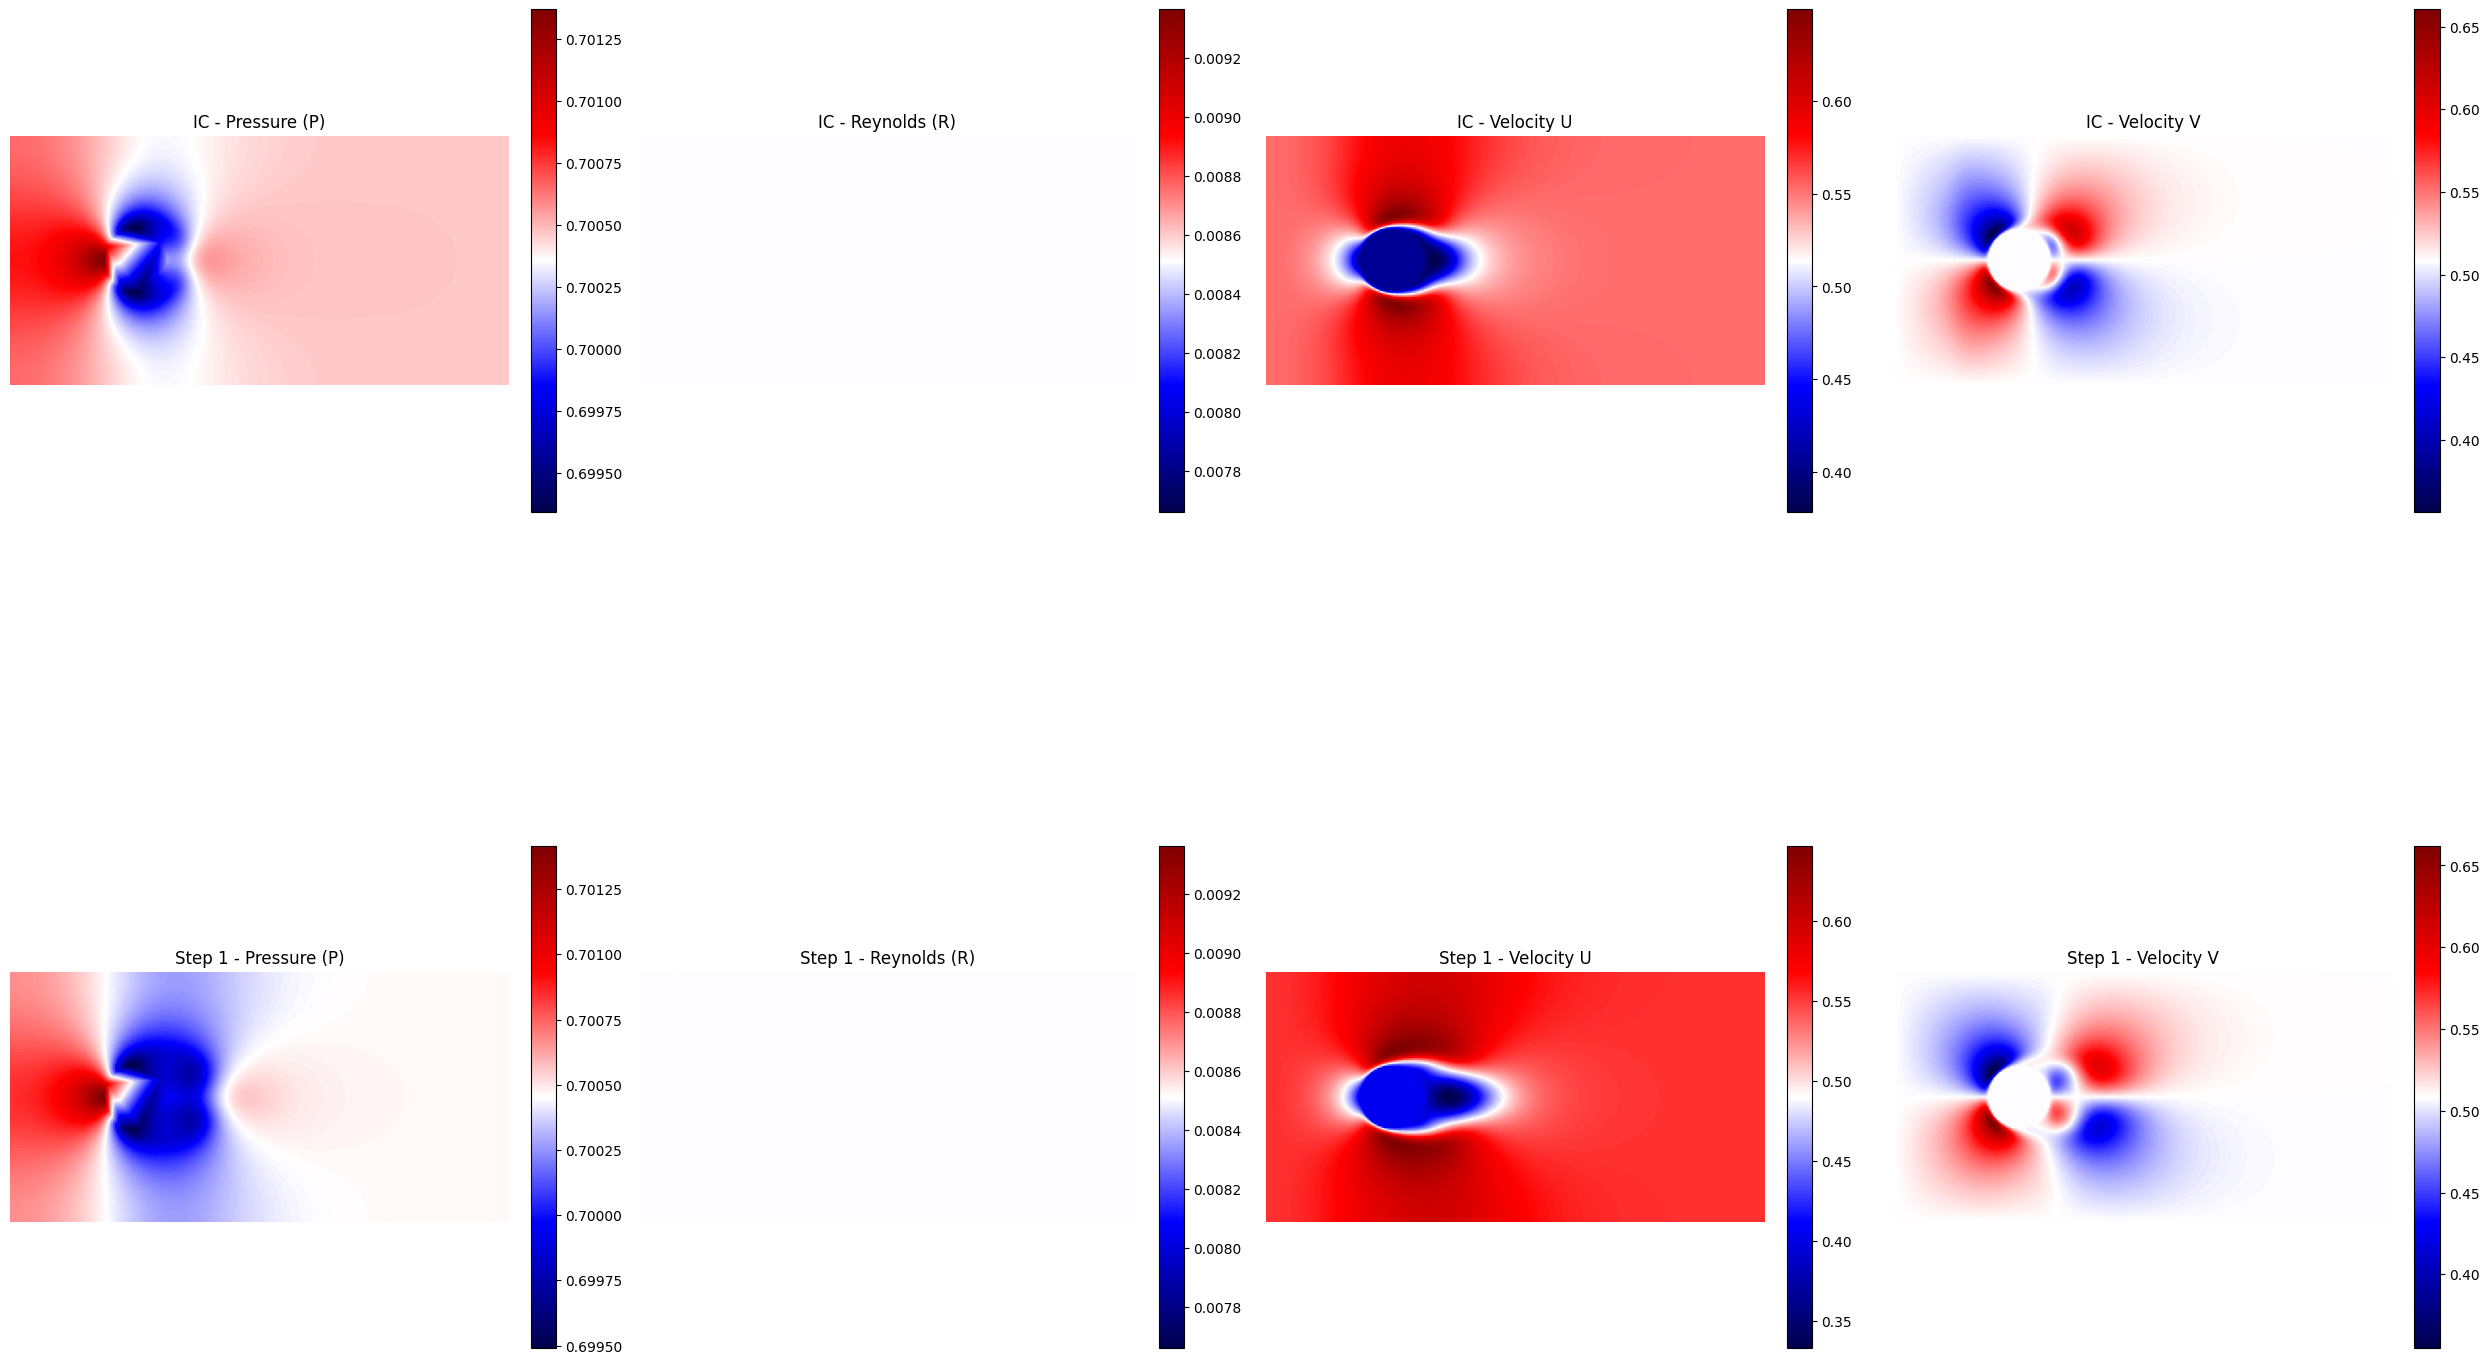

In [12]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = [
        "Pressure (P)",
        "Reynolds (R)",
        "Velocity U",
        "Velocity V",
    ]
    custom_cmaps = ["seismic", "seismic", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

<h2>Build Your PARC Model</h2>
<p>In this section, we are constructing a <strong>PARCv2 model</strong>, which is designed to handle spatiotemporal data, such as fluid dynamics simulations. The model leverages various components, including <em>differentiators</em> and <em>integrators</em>, to solve physical equations like Navier-Stokes.</p>

<p><strong>Key Components:</strong></p>
<ul>
    <li><strong>UNet:</strong> The UNet architecture is used for feature extraction, transforming the input data into a higher-dimensional representation. This helps the model capture complex patterns in the physical simulation data.</li>
    <li><strong>FiniteDifference:</strong> This differentiator approximates the gradients (or derivatives) of the input data using a finite difference method, which is important for calculating advection and diffusion processes in fluid dynamics.</li>
    <li><strong>Heun Integrator:</strong> Heun’s method is an improved version of Euler's method, used here to integrate the equations of motion more accurately over time.</li>
    <li><strong>Differentiator:</strong> This module calculates the advection and diffusion terms based on specific channel indices, such as velocity in the x and y directions (u and v).</li>
    <li><strong>Integrator:</strong> The integrator applies Heun’s method to combine the differentiated terms and solve the Poisson equation, ensuring the physical constraints of the system are respected.</li>
</ul>

<p>The model is then wrapped into the <strong>PARCv2</strong> class, which combines the differentiator, integrator, and loss function (<code>L1Loss</code>). Finally, an <code>Adam</code> optimizer is initialized to train the model by adjusting its parameters to minimize the error between predictions and ground truth data.</p>

<p>This setup allows the model to learn how to predict future states in complex physical systems by embedding domain-specific knowledge.</p>


In [13]:
import sys

sys.path.append("../../")

In [14]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

In [15]:
from torch.optim import Adam

In [16]:
# Defining Navier-Stokes variables: 
# p = pressure, re = Reynolds number, u = velocity in x-direction, v = velocity in y-direction
# Advection (Adv) and Diffusion (Dif) will be calculated on u, v
# Poisson equation (Poi) will be calculated on pressure (p)

n_fe_features = 128  # Number of features extracted by the UNet

# Initialize the UNet architecture for feature extraction
unet_ns = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],  # Channel dimensions at different levels of the UNet
    4,  # Number of input channels: p, re, u, v
    n_fe_features,  # Number of output features (feature extraction capacity)
    up_block_use_concat=[False, True, False, True],  # Control whether to use concatenation in upsampling blocks
    skip_connection_indices=[2, 0],  # Indices of skip connections for UNet (residual connections)
)

# Initialize finite difference method for numerical differentiation
right_diff = FiniteDifference(padding_mode="replicate").cuda()  # Use replication padding to handle boundary conditions

# Initialize Heun's method for numerical integration
heun_int = Heun().cuda()  # Heun's method is a second-order integrator (similar to improved Euler's method)

# Create the Differentiator, responsible for calculating advection and diffusion
diff_ns = Differentiator(
    2,  # Number of state variables (p, re), with u and v as velocity channels (indices 2 and 3)
    n_fe_features,  # Number of features returned by the feature extraction network
    [2, 3],  # Channel indices for advection calculation (u, v)
    [2, 3],  # Channel indices for diffusion calculation (u, v)
    unet_ns,  # Feature extraction network (UNet used to extract features from the state variables)
    "constant",  # Padding mode: constant padding (zeros at the boundary)
    right_diff,  # Use finite difference method for gradient calculations
    False # Random noise for Spade
).cuda()

# Create the Integrator, responsible for solving the Poisson equation and performing integration
ns_int = Integrator(
    True,  # Clip the input data between 0 and 1 to prevent extreme values
    [(0, 2, 3, 1)],  # Calculate Poisson on indices u and v (2 and 3), output the result to p (index 0)
    heun_int,  # Use Heun's method for integration of the Navier-Stokes equations
    [None, None, None, None],  # No additional data-driven integrators for now
    "constant",  # Padding mode: constant padding of zero at boundaries
    right_diff,  # Finite difference method for handling derivatives
).cuda()

# Define the loss function (L1 Loss is typically used for regression tasks)
criterion = torch.nn.L1Loss().cuda()

# Initialize the PARCv2 model with the differentiator, integrator, and loss function
model = PARCv2(diff_ns, ns_int, criterion).cuda()

# Set up the optimizer (Adam is a popular choice for adaptive learning rate optimization)
optimizer = Adam(model.parameters(), lr=1e-5)  # Learning rate set to 1e-5


## Train the Model 

In [17]:
from train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=250,
    save_dir="../../../weights/ns",
    app = "ns"
)


Epoch 1/250: 100%|██████████| 133/133 [00:28<00:00,  4.73it/s, Batch Loss=0.313]  

Epoch [1/250], Average Loss: 0.0792
Model weights saved at ../../../weights/ns/model.pth



Epoch 2/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.313]  

Epoch [2/250], Average Loss: 0.0735
Model weights saved at ../../../weights/ns/model.pth



Epoch 3/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.314]  

Epoch [3/250], Average Loss: 0.0739
Model weights saved at ../../../weights/ns/model.pth



Epoch 4/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.315]  

Epoch [4/250], Average Loss: 0.0738
Model weights saved at ../../../weights/ns/model.pth



Epoch 5/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.315]  

Epoch [5/250], Average Loss: 0.0735
Model weights saved at ../../../weights/ns/model.pth



Epoch 6/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.314]  

Epoch [6/250], Average Loss: 0.0732
Model weights saved at ../../../weights/ns/model.pth



Epoch 7/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.315]  

Epoch [7/250], Average Loss: 0.0733
Model weights saved at ../../../weights/ns/model.pth



Epoch 8/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.31]   

Epoch [8/250], Average Loss: 0.0714
Model weights saved at ../../../weights/ns/model.pth



Epoch 9/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.309]  

Epoch [9/250], Average Loss: 0.0707
Model weights saved at ../../../weights/ns/model.pth



Epoch 10/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.306]  

Epoch [10/250], Average Loss: 0.0691
Model weights saved at ../../../weights/ns/model.pth



Epoch 11/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.306]  

Epoch [11/250], Average Loss: 0.0690
Model weights saved at ../../../weights/ns/model.pth



Epoch 12/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [12/250], Average Loss: 0.0680
Model weights saved at ../../../weights/ns/model.pth



Epoch 13/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.305]  

Epoch [13/250], Average Loss: 0.0681
Model weights saved at ../../../weights/ns/model.pth



Epoch 14/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [14/250], Average Loss: 0.0675
Model weights saved at ../../../weights/ns/model.pth



Epoch 15/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [15/250], Average Loss: 0.0675
Model weights saved at ../../../weights/ns/model.pth



Epoch 16/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.305]  

Epoch [16/250], Average Loss: 0.0674
Model weights saved at ../../../weights/ns/model.pth



Epoch 17/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.303]  

Epoch [17/250], Average Loss: 0.0669
Model weights saved at ../../../weights/ns/model.pth



Epoch 18/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [18/250], Average Loss: 0.0673
Model weights saved at ../../../weights/ns/model.pth



Epoch 19/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.305]  

Epoch [19/250], Average Loss: 0.0671
Model weights saved at ../../../weights/ns/model.pth



Epoch 20/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.303]  

Epoch [20/250], Average Loss: 0.0665
Model weights saved at ../../../weights/ns/model.pth



Epoch 21/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.304]  

Epoch [21/250], Average Loss: 0.0670
Model weights saved at ../../../weights/ns/model.pth



Epoch 22/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.304]  

Epoch [22/250], Average Loss: 0.0666
Model weights saved at ../../../weights/ns/model.pth



Epoch 23/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [23/250], Average Loss: 0.0668
Model weights saved at ../../../weights/ns/model.pth



Epoch 24/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.303]  

Epoch [24/250], Average Loss: 0.0662
Model weights saved at ../../../weights/ns/model.pth



Epoch 25/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [25/250], Average Loss: 0.0667
Model weights saved at ../../../weights/ns/model.pth



Epoch 26/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.303]  

Epoch [26/250], Average Loss: 0.0661
Model weights saved at ../../../weights/ns/model.pth



Epoch 27/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [27/250], Average Loss: 0.0665
Model weights saved at ../../../weights/ns/model.pth



Epoch 28/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.303]  

Epoch [28/250], Average Loss: 0.0659
Model weights saved at ../../../weights/ns/model.pth



Epoch 29/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304]  

Epoch [29/250], Average Loss: 0.0663
Model weights saved at ../../../weights/ns/model.pth



Epoch 30/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.303] 

Epoch [30/250], Average Loss: 0.0657
Model weights saved at ../../../weights/ns/model.pth



Epoch 31/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.304] 

Epoch [31/250], Average Loss: 0.0661
Model weights saved at ../../../weights/ns/model.pth



Epoch 32/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.303]  

Epoch [32/250], Average Loss: 0.0657
Model weights saved at ../../../weights/ns/model.pth



Epoch 33/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.302]  

Epoch [33/250], Average Loss: 0.0657
Model weights saved at ../../../weights/ns/model.pth



Epoch 34/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.301]  

Epoch [34/250], Average Loss: 0.0653
Model weights saved at ../../../weights/ns/model.pth



Epoch 35/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.302]  

Epoch [35/250], Average Loss: 0.0654
Model weights saved at ../../../weights/ns/model.pth



Epoch 36/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.3]    

Epoch [36/250], Average Loss: 0.0646
Model weights saved at ../../../weights/ns/model.pth



Epoch 37/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.299]  

Epoch [37/250], Average Loss: 0.0644
Model weights saved at ../../../weights/ns/model.pth



Epoch 38/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.298]  

Epoch [38/250], Average Loss: 0.0639
Model weights saved at ../../../weights/ns/model.pth



Epoch 39/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.297]  

Epoch [39/250], Average Loss: 0.0637
Model weights saved at ../../../weights/ns/model.pth



Epoch 40/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.296]  

Epoch [40/250], Average Loss: 0.0633
Model weights saved at ../../../weights/ns/model.pth



Epoch 41/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.295]  

Epoch [41/250], Average Loss: 0.0630
Model weights saved at ../../../weights/ns/model.pth



Epoch 42/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.296] 

Epoch [42/250], Average Loss: 0.0631
Model weights saved at ../../../weights/ns/model.pth



Epoch 43/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.295]  

Epoch [43/250], Average Loss: 0.0626
Model weights saved at ../../../weights/ns/model.pth



Epoch 44/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.295]  

Epoch [44/250], Average Loss: 0.0625
Model weights saved at ../../../weights/ns/model.pth



Epoch 45/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.294]  

Epoch [45/250], Average Loss: 0.0623
Model weights saved at ../../../weights/ns/model.pth



Epoch 46/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.294]  

Epoch [46/250], Average Loss: 0.0622
Model weights saved at ../../../weights/ns/model.pth



Epoch 47/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.293]  

Epoch [47/250], Average Loss: 0.0620
Model weights saved at ../../../weights/ns/model.pth



Epoch 48/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.293]  

Epoch [48/250], Average Loss: 0.0619
Model weights saved at ../../../weights/ns/model.pth



Epoch 49/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.293]  

Epoch [49/250], Average Loss: 0.0618
Model weights saved at ../../../weights/ns/model.pth



Epoch 50/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.292]  

Epoch [50/250], Average Loss: 0.0617
Model weights saved at ../../../weights/ns/model.pth



Epoch 51/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.293]  

Epoch [51/250], Average Loss: 0.0617
Model weights saved at ../../../weights/ns/model.pth



Epoch 52/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.292] 

Epoch [52/250], Average Loss: 0.0615
Model weights saved at ../../../weights/ns/model.pth



Epoch 53/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.291]  

Epoch [53/250], Average Loss: 0.0614
Model weights saved at ../../../weights/ns/model.pth



Epoch 54/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.291]  

Epoch [54/250], Average Loss: 0.0612
Model weights saved at ../../../weights/ns/model.pth



Epoch 55/250: 100%|██████████| 133/133 [00:26<00:00,  4.97it/s, Batch Loss=0.29]   

Epoch [55/250], Average Loss: 0.0611
Model weights saved at ../../../weights/ns/model.pth



Epoch 56/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.291]  

Epoch [56/250], Average Loss: 0.0613
Model weights saved at ../../../weights/ns/model.pth



Epoch 57/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.289]  

Epoch [57/250], Average Loss: 0.0610
Model weights saved at ../../../weights/ns/model.pth



Epoch 58/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.29]   

Epoch [58/250], Average Loss: 0.0611
Model weights saved at ../../../weights/ns/model.pth



Epoch 59/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.288]  

Epoch [59/250], Average Loss: 0.0606
Model weights saved at ../../../weights/ns/model.pth



Epoch 60/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.288]  

Epoch [60/250], Average Loss: 0.0606
Model weights saved at ../../../weights/ns/model.pth



Epoch 61/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.288]  

Epoch [61/250], Average Loss: 0.0608
Model weights saved at ../../../weights/ns/model.pth



Epoch 62/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.288]  

Epoch [62/250], Average Loss: 0.0603
Model weights saved at ../../../weights/ns/model.pth



Epoch 63/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.287]  

Epoch [63/250], Average Loss: 0.0605
Model weights saved at ../../../weights/ns/model.pth



Epoch 64/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.287]  

Epoch [64/250], Average Loss: 0.0601
Model weights saved at ../../../weights/ns/model.pth



Epoch 65/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.287]  

Epoch [65/250], Average Loss: 0.0603
Model weights saved at ../../../weights/ns/model.pth



Epoch 66/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.287]  

Epoch [66/250], Average Loss: 0.0599
Model weights saved at ../../../weights/ns/model.pth



Epoch 67/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.287]  

Epoch [67/250], Average Loss: 0.0599
Model weights saved at ../../../weights/ns/model.pth



Epoch 68/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.286]  

Epoch [68/250], Average Loss: 0.0597
Model weights saved at ../../../weights/ns/model.pth



Epoch 69/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.286]  

Epoch [69/250], Average Loss: 0.0600
Model weights saved at ../../../weights/ns/model.pth



Epoch 70/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.285]  

Epoch [70/250], Average Loss: 0.0595
Model weights saved at ../../../weights/ns/model.pth



Epoch 71/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.286]  

Epoch [71/250], Average Loss: 0.0598
Model weights saved at ../../../weights/ns/model.pth



Epoch 72/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.285]  

Epoch [72/250], Average Loss: 0.0593
Model weights saved at ../../../weights/ns/model.pth



Epoch 73/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.284]  

Epoch [73/250], Average Loss: 0.0591
Model weights saved at ../../../weights/ns/model.pth



Epoch 74/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.284]  

Epoch [74/250], Average Loss: 0.0592
Model weights saved at ../../../weights/ns/model.pth



Epoch 75/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.284]  

Epoch [75/250], Average Loss: 0.0588
Model weights saved at ../../../weights/ns/model.pth



Epoch 76/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.284]  

Epoch [76/250], Average Loss: 0.0591
Model weights saved at ../../../weights/ns/model.pth



Epoch 77/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.284]  

Epoch [77/250], Average Loss: 0.0586
Model weights saved at ../../../weights/ns/model.pth



Epoch 78/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.284]  

Epoch [78/250], Average Loss: 0.0583
Model weights saved at ../../../weights/ns/model.pth



Epoch 79/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.283] 

Epoch [79/250], Average Loss: 0.0584
Model weights saved at ../../../weights/ns/model.pth



Epoch 80/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.283]  

Epoch [80/250], Average Loss: 0.0580
Model weights saved at ../../../weights/ns/model.pth



Epoch 81/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.283] 

Epoch [81/250], Average Loss: 0.0580
Model weights saved at ../../../weights/ns/model.pth



Epoch 82/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.282] 

Epoch [82/250], Average Loss: 0.0577
Model weights saved at ../../../weights/ns/model.pth



Epoch 83/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.282] 

Epoch [83/250], Average Loss: 0.0579
Model weights saved at ../../../weights/ns/model.pth



Epoch 84/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.281] 

Epoch [84/250], Average Loss: 0.0575
Model weights saved at ../../../weights/ns/model.pth



Epoch 85/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.281] 

Epoch [85/250], Average Loss: 0.0577
Model weights saved at ../../../weights/ns/model.pth



Epoch 86/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.28]  

Epoch [86/250], Average Loss: 0.0573
Model weights saved at ../../../weights/ns/model.pth



Epoch 87/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.28]  

Epoch [87/250], Average Loss: 0.0572
Model weights saved at ../../../weights/ns/model.pth



Epoch 88/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.279] 

Epoch [88/250], Average Loss: 0.0572
Model weights saved at ../../../weights/ns/model.pth



Epoch 89/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.279] 

Epoch [89/250], Average Loss: 0.0572
Model weights saved at ../../../weights/ns/model.pth



Epoch 90/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.279] 

Epoch [90/250], Average Loss: 0.0572
Model weights saved at ../../../weights/ns/model.pth



Epoch 91/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.278] 

Epoch [91/250], Average Loss: 0.0570
Model weights saved at ../../../weights/ns/model.pth



Epoch 92/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.278] 

Epoch [92/250], Average Loss: 0.0573
Model weights saved at ../../../weights/ns/model.pth



Epoch 93/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.277] 

Epoch [93/250], Average Loss: 0.0569
Model weights saved at ../../../weights/ns/model.pth



Epoch 94/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.278] 

Epoch [94/250], Average Loss: 0.0570
Model weights saved at ../../../weights/ns/model.pth



Epoch 95/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.277] 

Epoch [95/250], Average Loss: 0.0568
Model weights saved at ../../../weights/ns/model.pth



Epoch 96/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.277] 

Epoch [96/250], Average Loss: 0.0571
Model weights saved at ../../../weights/ns/model.pth



Epoch 97/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.277] 

Epoch [97/250], Average Loss: 0.0566
Model weights saved at ../../../weights/ns/model.pth



Epoch 98/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.277] 

Epoch [98/250], Average Loss: 0.0568
Model weights saved at ../../../weights/ns/model.pth



Epoch 99/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.276] 

Epoch [99/250], Average Loss: 0.0566
Model weights saved at ../../../weights/ns/model.pth



Epoch 100/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.276] 

Epoch [100/250], Average Loss: 0.0566
Model weights saved at ../../../weights/ns/model.pth



Epoch 101/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.276] 

Epoch [101/250], Average Loss: 0.0565
Model weights saved at ../../../weights/ns/model.pth



Epoch 102/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.276] 

Epoch [102/250], Average Loss: 0.0565
Model weights saved at ../../../weights/ns/model.pth



Epoch 103/250: 100%|██████████| 133/133 [00:26<00:00,  5.04it/s, Batch Loss=0.275] 

Epoch [103/250], Average Loss: 0.0563
Model weights saved at ../../../weights/ns/model.pth



Epoch 104/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.275] 

Epoch [104/250], Average Loss: 0.0566
Model weights saved at ../../../weights/ns/model.pth



Epoch 105/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.275] 

Epoch [105/250], Average Loss: 0.0562
Model weights saved at ../../../weights/ns/model.pth



Epoch 106/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.275] 

Epoch [106/250], Average Loss: 0.0565
Model weights saved at ../../../weights/ns/model.pth



Epoch 107/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.274] 


Epoch [107/250], Average Loss: 0.0561
Model weights saved at ../../../weights/ns/model.pth


Epoch 108/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.274] 

Epoch [108/250], Average Loss: 0.0563
Model weights saved at ../../../weights/ns/model.pth



Epoch 109/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.274] 

Epoch [109/250], Average Loss: 0.0560
Model weights saved at ../../../weights/ns/model.pth



Epoch 110/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.274] 

Epoch [110/250], Average Loss: 0.0563
Model weights saved at ../../../weights/ns/model.pth



Epoch 111/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.273] 

Epoch [111/250], Average Loss: 0.0560
Model weights saved at ../../../weights/ns/model.pth



Epoch 112/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.273] 

Epoch [112/250], Average Loss: 0.0560
Model weights saved at ../../../weights/ns/model.pth



Epoch 113/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.272] 

Epoch [113/250], Average Loss: 0.0557
Model weights saved at ../../../weights/ns/model.pth



Epoch 114/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.272] 

Epoch [114/250], Average Loss: 0.0561
Model weights saved at ../../../weights/ns/model.pth



Epoch 115/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.271] 

Epoch [115/250], Average Loss: 0.0556
Model weights saved at ../../../weights/ns/model.pth



Epoch 116/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.271] 

Epoch [116/250], Average Loss: 0.0560
Model weights saved at ../../../weights/ns/model.pth



Epoch 117/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.27]  

Epoch [117/250], Average Loss: 0.0555
Model weights saved at ../../../weights/ns/model.pth



Epoch 118/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.27]  

Epoch [118/250], Average Loss: 0.0556
Model weights saved at ../../../weights/ns/model.pth



Epoch 119/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.269] 

Epoch [119/250], Average Loss: 0.0554
Model weights saved at ../../../weights/ns/model.pth



Epoch 120/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.269] 

Epoch [120/250], Average Loss: 0.0558
Model weights saved at ../../../weights/ns/model.pth



Epoch 121/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.268] 

Epoch [121/250], Average Loss: 0.0553
Model weights saved at ../../../weights/ns/model.pth



Epoch 122/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.267] 

Epoch [122/250], Average Loss: 0.0555
Model weights saved at ../../../weights/ns/model.pth



Epoch 123/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.266] 

Epoch [123/250], Average Loss: 0.0551
Model weights saved at ../../../weights/ns/model.pth



Epoch 124/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.265] 

Epoch [124/250], Average Loss: 0.0553
Model weights saved at ../../../weights/ns/model.pth



Epoch 125/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.263] 

Epoch [125/250], Average Loss: 0.0550
Model weights saved at ../../../weights/ns/model.pth



Epoch 126/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.262] 

Epoch [126/250], Average Loss: 0.0551
Model weights saved at ../../../weights/ns/model.pth



Epoch 127/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.26]  

Epoch [127/250], Average Loss: 0.0548
Model weights saved at ../../../weights/ns/model.pth



Epoch 128/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.258] 

Epoch [128/250], Average Loss: 0.0550
Model weights saved at ../../../weights/ns/model.pth



Epoch 129/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.255] 

Epoch [129/250], Average Loss: 0.0546
Model weights saved at ../../../weights/ns/model.pth



Epoch 130/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.251] 

Epoch [130/250], Average Loss: 0.0545
Model weights saved at ../../../weights/ns/model.pth



Epoch 131/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.247] 

Epoch [131/250], Average Loss: 0.0543
Model weights saved at ../../../weights/ns/model.pth



Epoch 132/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.242] 

Epoch [132/250], Average Loss: 0.0543
Model weights saved at ../../../weights/ns/model.pth



Epoch 133/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.235] 

Epoch [133/250], Average Loss: 0.0538
Model weights saved at ../../../weights/ns/model.pth



Epoch 134/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.228] 

Epoch [134/250], Average Loss: 0.0537
Model weights saved at ../../../weights/ns/model.pth



Epoch 135/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.221]  

Epoch [135/250], Average Loss: 0.0531
Model weights saved at ../../../weights/ns/model.pth



Epoch 136/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.221]  

Epoch [136/250], Average Loss: 0.0530
Model weights saved at ../../../weights/ns/model.pth



Epoch 137/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.223]  

Epoch [137/250], Average Loss: 0.0527
Model weights saved at ../../../weights/ns/model.pth



Epoch 138/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.225]  

Epoch [138/250], Average Loss: 0.0527
Model weights saved at ../../../weights/ns/model.pth



Epoch 139/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.226]  

Epoch [139/250], Average Loss: 0.0521
Model weights saved at ../../../weights/ns/model.pth



Epoch 140/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.224]  

Epoch [140/250], Average Loss: 0.0519
Model weights saved at ../../../weights/ns/model.pth



Epoch 141/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.219]  

Epoch [141/250], Average Loss: 0.0511
Model weights saved at ../../../weights/ns/model.pth



Epoch 142/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.215]  

Epoch [142/250], Average Loss: 0.0506
Model weights saved at ../../../weights/ns/model.pth



Epoch 143/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.21]   

Epoch [143/250], Average Loss: 0.0503
Model weights saved at ../../../weights/ns/model.pth



Epoch 144/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.206]  

Epoch [144/250], Average Loss: 0.0496
Model weights saved at ../../../weights/ns/model.pth



Epoch 145/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.201]  

Epoch [145/250], Average Loss: 0.0492
Model weights saved at ../../../weights/ns/model.pth



Epoch 146/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.197]  

Epoch [146/250], Average Loss: 0.0490
Model weights saved at ../../../weights/ns/model.pth



Epoch 147/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.195]  

Epoch [147/250], Average Loss: 0.0485
Model weights saved at ../../../weights/ns/model.pth



Epoch 148/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.191]  

Epoch [148/250], Average Loss: 0.0481
Model weights saved at ../../../weights/ns/model.pth



Epoch 149/250: 100%|██████████| 133/133 [00:26<00:00,  5.04it/s, Batch Loss=0.189]  

Epoch [149/250], Average Loss: 0.0480
Model weights saved at ../../../weights/ns/model.pth



Epoch 150/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.182]  

Epoch [150/250], Average Loss: 0.0472
Model weights saved at ../../../weights/ns/model.pth



Epoch 151/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.179]  

Epoch [151/250], Average Loss: 0.0472
Model weights saved at ../../../weights/ns/model.pth



Epoch 152/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.176]  

Epoch [152/250], Average Loss: 0.0465
Model weights saved at ../../../weights/ns/model.pth



Epoch 153/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.174]  

Epoch [153/250], Average Loss: 0.0465
Model weights saved at ../../../weights/ns/model.pth



Epoch 154/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.171]  

Epoch [154/250], Average Loss: 0.0464
Model weights saved at ../../../weights/ns/model.pth



Epoch 155/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.169]  

Epoch [155/250], Average Loss: 0.0460
Model weights saved at ../../../weights/ns/model.pth



Epoch 156/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.166]  

Epoch [156/250], Average Loss: 0.0459
Model weights saved at ../../../weights/ns/model.pth



Epoch 157/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.165]  

Epoch [157/250], Average Loss: 0.0457
Model weights saved at ../../../weights/ns/model.pth



Epoch 158/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.163] 

Epoch [158/250], Average Loss: 0.0456
Model weights saved at ../../../weights/ns/model.pth



Epoch 159/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.161]  

Epoch [159/250], Average Loss: 0.0454
Model weights saved at ../../../weights/ns/model.pth



Epoch 160/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.16]  

Epoch [160/250], Average Loss: 0.0452
Model weights saved at ../../../weights/ns/model.pth



Epoch 161/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.159]  

Epoch [161/250], Average Loss: 0.0452
Model weights saved at ../../../weights/ns/model.pth



Epoch 162/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.157]  

Epoch [162/250], Average Loss: 0.0450
Model weights saved at ../../../weights/ns/model.pth



Epoch 163/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.156]  

Epoch [163/250], Average Loss: 0.0448
Model weights saved at ../../../weights/ns/model.pth



Epoch 164/250: 100%|██████████| 133/133 [00:26<00:00,  5.05it/s, Batch Loss=0.155]  

Epoch [164/250], Average Loss: 0.0446
Model weights saved at ../../../weights/ns/model.pth



Epoch 165/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.154]  

Epoch [165/250], Average Loss: 0.0447
Model weights saved at ../../../weights/ns/model.pth



Epoch 166/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.153]  

Epoch [166/250], Average Loss: 0.0446
Model weights saved at ../../../weights/ns/model.pth



Epoch 167/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.152]  

Epoch [167/250], Average Loss: 0.0444
Model weights saved at ../../../weights/ns/model.pth



Epoch 168/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.152]  

Epoch [168/250], Average Loss: 0.0444
Model weights saved at ../../../weights/ns/model.pth



Epoch 169/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.151]  

Epoch [169/250], Average Loss: 0.0443
Model weights saved at ../../../weights/ns/model.pth



Epoch 170/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.15]   

Epoch [170/250], Average Loss: 0.0440
Model weights saved at ../../../weights/ns/model.pth



Epoch 171/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.149]  

Epoch [171/250], Average Loss: 0.0440
Model weights saved at ../../../weights/ns/model.pth



Epoch 172/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.148]  

Epoch [172/250], Average Loss: 0.0438
Model weights saved at ../../../weights/ns/model.pth



Epoch 173/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.148]  

Epoch [173/250], Average Loss: 0.0438
Model weights saved at ../../../weights/ns/model.pth



Epoch 174/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.147] 

Epoch [174/250], Average Loss: 0.0436
Model weights saved at ../../../weights/ns/model.pth



Epoch 175/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.146]  

Epoch [175/250], Average Loss: 0.0435
Model weights saved at ../../../weights/ns/model.pth



Epoch 176/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.144]  

Epoch [176/250], Average Loss: 0.0433
Model weights saved at ../../../weights/ns/model.pth



Epoch 177/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.143]  

Epoch [177/250], Average Loss: 0.0432
Model weights saved at ../../../weights/ns/model.pth



Epoch 178/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.142]  

Epoch [178/250], Average Loss: 0.0430
Model weights saved at ../../../weights/ns/model.pth



Epoch 179/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.141]  

Epoch [179/250], Average Loss: 0.0429
Model weights saved at ../../../weights/ns/model.pth



Epoch 180/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.139]  

Epoch [180/250], Average Loss: 0.0430
Model weights saved at ../../../weights/ns/model.pth



Epoch 181/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.136]  

Epoch [181/250], Average Loss: 0.0424
Model weights saved at ../../../weights/ns/model.pth



Epoch 182/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.132]  

Epoch [182/250], Average Loss: 0.0421
Model weights saved at ../../../weights/ns/model.pth



Epoch 183/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.131]  

Epoch [183/250], Average Loss: 0.0421
Model weights saved at ../../../weights/ns/model.pth



Epoch 184/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.134]  

Epoch [184/250], Average Loss: 0.0418
Model weights saved at ../../../weights/ns/model.pth



Epoch 185/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.128]  

Epoch [185/250], Average Loss: 0.0415
Model weights saved at ../../../weights/ns/model.pth



Epoch 186/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.147]  

Epoch [186/250], Average Loss: 0.0423
Model weights saved at ../../../weights/ns/model.pth



Epoch 187/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.124]  

Epoch [187/250], Average Loss: 0.0414
Model weights saved at ../../../weights/ns/model.pth



Epoch 188/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.148]  

Epoch [188/250], Average Loss: 0.0422
Model weights saved at ../../../weights/ns/model.pth



Epoch 189/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.121]  

Epoch [189/250], Average Loss: 0.0412
Model weights saved at ../../../weights/ns/model.pth



Epoch 190/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.15]   

Epoch [190/250], Average Loss: 0.0422
Model weights saved at ../../../weights/ns/model.pth



Epoch 191/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.13]   

Epoch [191/250], Average Loss: 0.0415
Model weights saved at ../../../weights/ns/model.pth



Epoch 192/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.132]  

Epoch [192/250], Average Loss: 0.0410
Model weights saved at ../../../weights/ns/model.pth



Epoch 193/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.124]  

Epoch [193/250], Average Loss: 0.0408
Model weights saved at ../../../weights/ns/model.pth



Epoch 194/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.151]  

Epoch [194/250], Average Loss: 0.0418
Model weights saved at ../../../weights/ns/model.pth



Epoch 195/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.143]  

Epoch [195/250], Average Loss: 0.0418
Model weights saved at ../../../weights/ns/model.pth



Epoch 196/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.114] 

Epoch [196/250], Average Loss: 0.0402
Model weights saved at ../../../weights/ns/model.pth



Epoch 197/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.153]  

Epoch [197/250], Average Loss: 0.0417
Model weights saved at ../../../weights/ns/model.pth



Epoch 198/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.151]  

Epoch [198/250], Average Loss: 0.0421
Model weights saved at ../../../weights/ns/model.pth



Epoch 199/250: 100%|██████████| 133/133 [00:26<00:00,  5.04it/s, Batch Loss=0.151]  

Epoch [199/250], Average Loss: 0.0416
Model weights saved at ../../../weights/ns/model.pth



Epoch 200/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.151]  

Epoch [200/250], Average Loss: 0.0415
Model weights saved at ../../../weights/ns/model.pth



Epoch 201/250: 100%|██████████| 133/133 [00:26<00:00,  5.03it/s, Batch Loss=0.153]  

Epoch [201/250], Average Loss: 0.0417
Model weights saved at ../../../weights/ns/model.pth



Epoch 202/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.15]   

Epoch [202/250], Average Loss: 0.0412
Model weights saved at ../../../weights/ns/model.pth



Epoch 203/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.151]  

Epoch [203/250], Average Loss: 0.0415
Model weights saved at ../../../weights/ns/model.pth



Epoch 204/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.148]  

Epoch [204/250], Average Loss: 0.0409
Model weights saved at ../../../weights/ns/model.pth



Epoch 205/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.151]  

Epoch [205/250], Average Loss: 0.0408
Model weights saved at ../../../weights/ns/model.pth



Epoch 206/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.152]  

Epoch [206/250], Average Loss: 0.0409
Model weights saved at ../../../weights/ns/model.pth



Epoch 207/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.148]  

Epoch [207/250], Average Loss: 0.0407
Model weights saved at ../../../weights/ns/model.pth



Epoch 208/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.146]  

Epoch [208/250], Average Loss: 0.0404
Model weights saved at ../../../weights/ns/model.pth



Epoch 209/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.15]   

Epoch [209/250], Average Loss: 0.0405
Model weights saved at ../../../weights/ns/model.pth



Epoch 210/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.145]  

Epoch [210/250], Average Loss: 0.0401
Model weights saved at ../../../weights/ns/model.pth



Epoch 211/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.148]  

Epoch [211/250], Average Loss: 0.0403
Model weights saved at ../../../weights/ns/model.pth



Epoch 212/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.141]  

Epoch [212/250], Average Loss: 0.0399
Model weights saved at ../../../weights/ns/model.pth



Epoch 213/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.144]  

Epoch [213/250], Average Loss: 0.0397
Model weights saved at ../../../weights/ns/model.pth



Epoch 214/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.144]  

Epoch [214/250], Average Loss: 0.0398
Model weights saved at ../../../weights/ns/model.pth



Epoch 215/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.149]  

Epoch [215/250], Average Loss: 0.0399
Model weights saved at ../../../weights/ns/model.pth



Epoch 216/250: 100%|██████████| 133/133 [00:26<00:00,  5.00it/s, Batch Loss=0.14]   

Epoch [216/250], Average Loss: 0.0397
Model weights saved at ../../../weights/ns/model.pth



Epoch 217/250: 100%|██████████| 133/133 [00:26<00:00,  5.04it/s, Batch Loss=0.143]  

Epoch [217/250], Average Loss: 0.0393
Model weights saved at ../../../weights/ns/model.pth



Epoch 218/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.14]   

Epoch [218/250], Average Loss: 0.0394
Model weights saved at ../../../weights/ns/model.pth



Epoch 219/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.136]  

Epoch [219/250], Average Loss: 0.0391
Model weights saved at ../../../weights/ns/model.pth



Epoch 220/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.137]  

Epoch [220/250], Average Loss: 0.0390
Model weights saved at ../../../weights/ns/model.pth



Epoch 221/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.139]  

Epoch [221/250], Average Loss: 0.0394
Model weights saved at ../../../weights/ns/model.pth



Epoch 222/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.137]  

Epoch [222/250], Average Loss: 0.0393
Model weights saved at ../../../weights/ns/model.pth



Epoch 223/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.134]  

Epoch [223/250], Average Loss: 0.0388
Model weights saved at ../../../weights/ns/model.pth



Epoch 224/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.142]  

Epoch [224/250], Average Loss: 0.0389
Model weights saved at ../../../weights/ns/model.pth



Epoch 225/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.142]  

Epoch [225/250], Average Loss: 0.0391
Model weights saved at ../../../weights/ns/model.pth



Epoch 226/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.138]  

Epoch [226/250], Average Loss: 0.0389
Model weights saved at ../../../weights/ns/model.pth



Epoch 227/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.135]  

Epoch [227/250], Average Loss: 0.0386
Model weights saved at ../../../weights/ns/model.pth



Epoch 228/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.133]  

Epoch [228/250], Average Loss: 0.0384
Model weights saved at ../../../weights/ns/model.pth



Epoch 229/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.142]  

Epoch [229/250], Average Loss: 0.0387
Model weights saved at ../../../weights/ns/model.pth



Epoch 230/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.139]  

Epoch [230/250], Average Loss: 0.0390
Model weights saved at ../../../weights/ns/model.pth



Epoch 231/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.138]  

Epoch [231/250], Average Loss: 0.0384
Model weights saved at ../../../weights/ns/model.pth



Epoch 232/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.131]  

Epoch [232/250], Average Loss: 0.0381
Model weights saved at ../../../weights/ns/model.pth



Epoch 233/250: 100%|██████████| 133/133 [00:26<00:00,  5.01it/s, Batch Loss=0.141]  

Epoch [233/250], Average Loss: 0.0388
Model weights saved at ../../../weights/ns/model.pth



Epoch 234/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.14]   

Epoch [234/250], Average Loss: 0.0387
Model weights saved at ../../../weights/ns/model.pth



Epoch 235/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.137]  

Epoch [235/250], Average Loss: 0.0382
Model weights saved at ../../../weights/ns/model.pth



Epoch 236/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.134]  

Epoch [236/250], Average Loss: 0.0382
Model weights saved at ../../../weights/ns/model.pth



Epoch 237/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.135]  

Epoch [237/250], Average Loss: 0.0381
Model weights saved at ../../../weights/ns/model.pth



Epoch 238/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.136]  

Epoch [238/250], Average Loss: 0.0381
Model weights saved at ../../../weights/ns/model.pth



Epoch 239/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.139]  

Epoch [239/250], Average Loss: 0.0382
Model weights saved at ../../../weights/ns/model.pth



Epoch 240/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.13]   

Epoch [240/250], Average Loss: 0.0379
Model weights saved at ../../../weights/ns/model.pth



Epoch 241/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.138]  

Epoch [241/250], Average Loss: 0.0381
Model weights saved at ../../../weights/ns/model.pth



Epoch 242/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.139]  

Epoch [242/250], Average Loss: 0.0382
Model weights saved at ../../../weights/ns/model.pth



Epoch 243/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.132]  

Epoch [243/250], Average Loss: 0.0376
Model weights saved at ../../../weights/ns/model.pth



Epoch 244/250: 100%|██████████| 133/133 [00:26<00:00,  4.99it/s, Batch Loss=0.136]  

Epoch [244/250], Average Loss: 0.0380
Model weights saved at ../../../weights/ns/model.pth



Epoch 245/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.134]  

Epoch [245/250], Average Loss: 0.0378
Model weights saved at ../../../weights/ns/model.pth



Epoch 246/250: 100%|██████████| 133/133 [00:26<00:00,  4.98it/s, Batch Loss=0.133]  

Epoch [246/250], Average Loss: 0.0377
Model weights saved at ../../../weights/ns/model.pth



Epoch 247/250: 100%|██████████| 133/133 [00:26<00:00,  5.06it/s, Batch Loss=0.134]  

Epoch [247/250], Average Loss: 0.0378
Model weights saved at ../../../weights/ns/model.pth



Epoch 248/250: 100%|██████████| 133/133 [00:26<00:00,  5.02it/s, Batch Loss=0.135]  

Epoch [248/250], Average Loss: 0.0378
Model weights saved at ../../../weights/ns/model.pth



Epoch 249/250: 100%|██████████| 133/133 [00:26<00:00,  5.04it/s, Batch Loss=0.138]  

Epoch [249/250], Average Loss: 0.0379
Model weights saved at ../../../weights/ns/model.pth



Epoch 250/250: 100%|██████████| 133/133 [00:26<00:00,  5.07it/s, Batch Loss=0.132]  

Epoch [250/250], Average Loss: 0.0376
Model weights saved at ../../../weights/ns/model.pth
Training losses saved at ../../../weights/ns/training_losses.pkl


## Load the Model

In [14]:
from utilities.load import load_model_weights


# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = (
    "/home/jtb3sud/hold/testnavier_stokes/model.pth"  # Replace with your path
)
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/home/jtb3sud/hold/testnavier_stokes/model.pth'


## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [11]:
# Initialize the dataset
future_steps = 10
seq_dataset = InitialConditionDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

2024-10-16 14:39:15,051 [INFO] Starting data validation...
2024-10-16 14:39:15,055 [INFO] Validating .npy files...
Validating files: 100%|██████████| 8/8 [00:00<00:00, 336.25it/s]
2024-10-16 14:39:15,083 [INFO] Data validation completed successfully.
2024-10-16 14:39:15,084 [INFO] Validating timesteps in each file...
Validating timesteps: 100%|██████████| 8/8 [00:00<00:00, 699.62it/s]


## Ground truth loader

In [12]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-10-16 14:39:15,103 [INFO] Starting data validation...
2024-10-16 14:39:15,107 [INFO] Validating .npy files...
Validating files: 100%|██████████| 8/8 [00:00<00:00, 630.11it/s]
2024-10-16 14:39:15,124 [INFO] Data validation completed successfully.
2024-10-16 14:39:15,125 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 8/8 [00:00<00:00, 761.79it/s]
2024-10-16 14:39:15,139 [INFO] Total samples in dataset: 232


## Visualize the Results

In [13]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["pressure", "Reynolds", "u", "v"]  # Adjust as per your data
cmaps = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset

Predictions shape: torch.Size([10, 8, 4, 128, 256])
Sample prediction for timestep 1: torch.Size([10, 4, 128, 256])
GIF saved to comparison_batch0_pressure.gif
GIF saved to comparison_batch0_Reynolds.gif
GIF saved to comparison_batch0_u.gif
GIF saved to comparison_batch0_v.gif
